In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean, absolute, sqrt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

#from mxnet import autograd, gluon, init, np, npx
#from mxnet.gluon import nn
#from d2l import mxnet as d2l
# The training dataset includes 1460 examples, 80 features, and 1 label, 
# while the test data contains 1459 examples and 80 features.

In [26]:
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')

In [27]:
price = dataset_train["SalePrice"]
all = pd.concat([dataset_train, dataset_test]).iloc[:,0:79]
print(all.dtypes[0:5])
#second column MSSubClass is categorical feature but is considered as 
#int so we remapped it

all["MSSubClass"] = all["MSSubClass"].astype(str)
all["MSSubClass"] = all["MSSubClass"].replace(["20","30","40","45","50","60","70","75","80","85","90","120","150"
                           , "160","180","190"], ["1-story_1946+","1-story_1945-", "1-story_with_finished_attic"
                           ,"1.5_story_unifinished", "1.5_finished", "2-story_1946+", "2-story_1945-",
                            "2.5_story", "split_or_multi_level", "split_foyer", "1-story_PUD",  "duplex",
                            "1.5_story_PUD", "2-story_PUD", "PUD_Multilevel","2_family_conversion"])
all["MSSubClass"].head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object


0    2-story_1946+
1    1-story_1946+
2    2-story_1946+
3    2-story_1945-
4    2-story_1946+
Name: MSSubClass, dtype: object

In [28]:
#modify yrs
#YearBuilt: Original construction date
#YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
#YrSold: Year Sold (YYYY)

# remodel 0 = no 1 =yes
# age: yr-sold - max(yearbulit, yearromodadd)

remod = all["YearBuilt"] == all["YearRemodAdd"]


remod = np.multiply(np.array(remod),1)
        
#HouseAge = all["YearBuilt"] - max(all["YearBuilt"], all["YearRemodAdd"])

HouseAge = all["YrSold"] - all[["YearBuilt", "YearRemodAdd"]].max(axis=1)
print(min(HouseAge))

all["HouseAge"] = HouseAge
all["remod"] = remod
all = all.drop(columns=["YearBuilt","YearRemodAdd","YrSold" ])
all


-2


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,HouseAge,remod
0,1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,WD,5,1
1,2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,WD,31,1
2,3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,WD,6,0
3,4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,WD,36,0
4,5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,WD,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2-story_PUD,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,WD,36,1
1455,2916,2-story_PUD,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,WD,36,1
1456,2917,1-story_1946+,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,WD,10,0
1457,2918,split_foyer,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,WD,14,1


In [29]:
#BsmtFullBath: Basement full bathrooms
#BsmtHalfBath: Basement half bathrooms
#FullBath: Full bathrooms above grade
#HalfBath: Half baths above grade

#A full bathroom is made up of four parts: a sink, a shower, a bathtub, and a toilet. Anything less than that, and you can't officially consider it a full bath
#A bathroom with just a sink and a toilet is a half-bath.

all['BsmtFullBath']  = all['BsmtFullBath'].fillna(0)
all['BsmtHalfBath']  = all['BsmtHalfBath'].fillna(0)

all['NumBath'] = all['BsmtFullBath'] + all['BsmtHalfBath'] *.5 + all['HalfBath'] + all['HalfBath'] * .5

all = all.drop(columns=['BsmtFullBath','BsmtHalfBath','HalfBath','HalfBath' ])

all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,HouseAge,remod,NumBath
0,1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,5,1,2.5
1,2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,WD,31,1,0.5
2,3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,6,0,2.5
3,4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,36,0,1.0
4,5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,WD,8,1,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2-story_PUD,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,WD,36,1,1.5
1455,2916,2-story_PUD,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,WD,36,1,1.5
1456,2917,1-story_1946+,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,10,0,1.0
1457,2918,split_foyer,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,WD,14,1,0.5


In [30]:
#garage variables

price

all['GarageArea']  = all['GarageArea'].fillna(0)
all['GarageCars']  = all['GarageCars'].fillna(0)

cor_Garage_area_cars = all['GarageArea'].corr(all['GarageCars'])
print("Since GarageArea and GarageCars are highly correlated (cor = ", round(cor_Garage_area_cars,4), ")\n")
print("in case of parsimony, we choose one of them has higher correlation with SalePrice")

print("correlation between GarageArea and SalePrice is", round(all['GarageArea'][0:1459].corr(price),4))
print("correlation between GarageCars and SalePrice is", round(all['GarageCars'][0:1459].corr(price),4))
print("so we keep the GarageCars variable")

all = all.drop(columns=['GarageArea' ])

all

Since GarageArea and GarageCars are highly correlated (cor =  0.8899 )

in case of parsimony, we choose one of them has higher correlation with SalePrice
correlation between GarageArea and SalePrice is 0.6234
correlation between GarageCars and SalePrice is 0.6404
so we keep the GarageCars variable


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,HouseAge,remod,NumBath
0,1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,5,1,2.5
1,2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,WD,31,1,0.5
2,3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,6,0,2.5
3,4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,36,0,1.0
4,5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,WD,8,1,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2-story_PUD,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,WD,36,1,1.5
1455,2916,2-story_PUD,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,WD,36,1,1.5
1456,2917,1-story_1946+,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,10,0,1.0
1457,2918,split_foyer,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,WD,14,1,0.5


In [31]:
#x1stFlrSF and totalbasement
#x1stF   + 2nd = grlivarea

df_test1 = all[['1stFlrSF', '2ndFlrSF', 'GrLivArea']]
df_test1['sum1and2'] = df_test1['1stFlrSF'] + df_test1['2ndFlrSF']
df_test1['DiffSumAndTot'] = df_test1['GrLivArea'] - df_test1['sum1and2'] 
print(df_test1[1:20])

print("we can see there are only", sum((all['1stFlrSF'] + all['2ndFlrSF']) != all['GrLivArea']) ,"out of 2919 data sets, approximately 1% of total data set\n",
      "that first floor area + second floor area != totol above ground living area, probably there are some houses has\n",
      "> 2 floors that has not been taken into account of the dataset")
print("so we comes to the conclusion that Total above ground living area('GrLivArea') explains both two variables\n")
print("first floor sf and second floor sq")
print("so we drop those two features")

all = all.drop(columns=['1stFlrSF','2ndFlrSF' ])

all

    1stFlrSF  2ndFlrSF  GrLivArea  sum1and2  DiffSumAndTot
1       1262         0       1262      1262              0
2        920       866       1786      1786              0
3        961       756       1717      1717              0
4       1145      1053       2198      2198              0
5        796       566       1362      1362              0
6       1694         0       1694      1694              0
7       1107       983       2090      2090              0
8       1022       752       1774      1774              0
9       1077         0       1077      1077              0
10      1040         0       1040      1040              0
11      1182      1142       2324      2324              0
12       912         0        912       912              0
13      1494         0       1494      1494              0
14      1253         0       1253      1253              0
15       854         0        854       854              0
16      1004         0       1004      1004             

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,HouseAge,remod,NumBath
0,1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,5,1,2.5
1,2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,WD,31,1,0.5
2,3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,6,0,2.5
3,4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,36,0,1.0
4,5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,WD,8,1,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2-story_PUD,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,WD,36,1,1.5
1455,2916,2-story_PUD,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,WD,36,1,1.5
1456,2917,1-story_1946+,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,10,0,1.0
1457,2918,split_foyer,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,WD,14,1,0.5


In [32]:
print("since Total # of rooms and above ground living area are highly correlated, cor = ", round(all['TotRmsAbvGrd'].corr(all['GrLivArea']),4))
print("so we choose one has higher correlation with SalePrice")
all = all.drop(columns=['TotRmsAbvGrd' ])
all



since Total # of rooms and above ground living area are highly correlated, cor =  0.8084
so we choose one has higher correlation with SalePrice


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,HouseAge,remod,NumBath
0,1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,5,1,2.5
1,2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,WD,31,1,0.5
2,3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,6,0,2.5
3,4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,WD,36,0,1.0
4,5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,WD,8,1,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2-story_PUD,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,WD,36,1,1.5
1455,2916,2-story_PUD,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,WD,36,1,1.5
1456,2917,1-story_1946+,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,WD,10,0,1.0
1457,2918,split_foyer,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,WD,14,1,0.5


In [33]:
all_features = all

# replacing all missing values by the corresponding feature’s mean. 
# Then, to put all features on a common scale, 
# we standardize the data by rescaling features to zero mean and unit variance
# Intuitively, we standardize the data for two reasons. 
# First, it proves convenient for optimization. 
# Second, because we do not know a priori which features will be relevant,
# we do not want to penalize coefficients assigned to one feature 
# more than on any other.


# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [34]:
# Next we deal with discrete values. 
# We replace them by a one-hot encoding
# Dummy variables
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 334)

In [35]:
all_features = all_features.iloc[:,1:] # exclude id

In [36]:
train = all_features.iloc[0:1460,]
train

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan
0,-0.184443,-0.217841,0.646073,-0.507197,0.523038,0.580708,-0.293030,-0.934542,-0.444176,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1,0.458096,-0.072032,-0.063174,2.187904,-0.569893,1.177709,-0.293030,-0.629681,0.476948,-0.10118,...,0,0,0,0,0,0,0,0,1,0
2,-0.055935,0.137173,0.646073,-0.507197,0.333448,0.097840,-0.293030,-0.288418,-0.298974,-0.10118,...,0,0,0,0,0,0,0,0,1,0
3,-0.398622,-0.078371,0.646073,-0.507197,-0.569893,-0.494771,-0.293030,-0.047258,-0.671053,-0.10118,...,0,0,0,0,0,0,0,0,1,0
4,0.629439,0.518814,1.355319,-0.507197,1.381770,0.468770,-0.293030,-0.161013,0.211501,-0.10118,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.312950,-0.285421,-0.063174,-0.507197,-0.569893,-0.968860,-0.293030,0.892353,-0.224104,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1456,0.672275,0.381246,-0.063174,0.391170,0.093673,0.765076,0.670295,0.064221,1.112205,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1457,-0.141607,-0.142781,0.646073,3.086271,-0.569893,-0.365275,-0.293030,0.719446,0.227382,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1458,-0.055935,-0.057197,-0.772420,0.391170,-0.569893,-0.861312,5.788329,-1.275805,0.059493,-0.10118,...,0,0,0,0,0,0,0,0,1,0


In [37]:
test = all_features.iloc[1460:,]
test

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan
0,0.458096,0.184340,-0.772420,0.391170,-0.569893,0.058332,0.558006,-0.661532,-0.385187,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1,0.500932,0.519702,-0.063174,0.391170,0.032335,1.056991,-0.293030,-0.352120,0.628956,-0.10118,...,0,0,0,0,0,0,0,0,1,0
2,0.201080,0.464294,-0.772420,-0.507197,-0.569893,0.767271,-0.293030,-0.964118,-0.280824,-0.10118,...,0,0,0,0,0,0,0,0,1,0
3,0.372424,-0.024105,-0.063174,0.391170,-0.458369,0.352443,-0.293030,-0.538677,-0.285361,-0.10118,...,0,0,0,0,0,0,0,0,1,0
4,-1.126832,-0.654636,1.355319,-0.507197,-0.569893,-0.391613,-0.293030,1.037958,0.517786,-0.10118,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-2.069222,-1.043758,-1.481667,1.289537,-0.569893,-0.968860,-0.293030,-0.033608,-1.147496,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1455,-2.069222,-1.049083,-1.481667,-0.507197,-0.569893,-0.415757,-0.293030,-0.606930,-1.147496,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1456,3.884968,1.246594,-0.772420,1.289537,-0.569893,1.717643,-0.293030,-1.275805,0.390734,-0.10118,...,0,0,0,0,0,0,0,0,1,0
1457,-0.312950,0.034599,-0.772420,-0.507197,-0.569893,-0.229194,-0.293030,0.032370,-0.317124,-0.10118,...,0,0,0,0,0,0,0,0,1,0


In [38]:
#split data into categorical and continuous variables for analysis
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_cont = train.select_dtypes(include=numerics)
df_cat = train.select_dtypes(include = 'object')

### Lasso

In [39]:
df = pd.concat([train, np.log(dataset_train['SalePrice'])], axis = 1)
df

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SalePrice
0,-0.184443,-0.217841,0.646073,-0.507197,0.523038,0.580708,-0.293030,-0.934542,-0.444176,-0.10118,...,0,0,0,0,0,0,0,1,0,12.247694
1,0.458096,-0.072032,-0.063174,2.187904,-0.569893,1.177709,-0.293030,-0.629681,0.476948,-0.10118,...,0,0,0,0,0,0,0,1,0,12.109011
2,-0.055935,0.137173,0.646073,-0.507197,0.333448,0.097840,-0.293030,-0.288418,-0.298974,-0.10118,...,0,0,0,0,0,0,0,1,0,12.317167
3,-0.398622,-0.078371,0.646073,-0.507197,-0.569893,-0.494771,-0.293030,-0.047258,-0.671053,-0.10118,...,0,0,0,0,0,0,0,1,0,11.849398
4,0.629439,0.518814,1.355319,-0.507197,1.381770,0.468770,-0.293030,-0.161013,0.211501,-0.10118,...,0,0,0,0,0,0,0,1,0,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.312950,-0.285421,-0.063174,-0.507197,-0.569893,-0.968860,-0.293030,0.892353,-0.224104,-0.10118,...,0,0,0,0,0,0,0,1,0,12.072541
1456,0.672275,0.381246,-0.063174,0.391170,0.093673,0.765076,0.670295,0.064221,1.112205,-0.10118,...,0,0,0,0,0,0,0,1,0,12.254863
1457,-0.141607,-0.142781,0.646073,3.086271,-0.569893,-0.365275,-0.293030,0.719446,0.227382,-0.10118,...,0,0,0,0,0,0,0,1,0,12.493130
1458,-0.055935,-0.057197,-0.772420,0.391170,-0.569893,-0.861312,5.788329,-1.275805,0.059493,-0.10118,...,0,0,0,0,0,0,0,1,0,11.864462


In [40]:
pd.options.display.max_seq_items = 2000
df.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF',
       'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'HouseAge', 'remod', 'NumBath', 'MSSubClass_1-story_1945-',
       'MSSubClass_1-story_1946+', 'MSSubClass_1-story_PUD',
       'MSSubClass_1-story_with_finished_attic', 'MSSubClass_1.5_finished',
       'MSSubClass_1.5_story_PUD', 'MSSubClass_1.5_story_unifinished',
       'MSSubClass_2-story_1945-', 'MSSubClass_2-story_1946+',
       'MSSubClass_2-story_PUD', 'MSSubClass_2.5_story',
       'MSSubClass_2_family_conversion', 'MSSubClass_PUD_Multilevel',
       'MSSubClass_duplex', 'MSSubClass_split_foyer',
       'MSSubClass_split_or_multi_level', 'MSSubClass_nan', 'MSZoning_C (all)',
       'MSZoning_

In [41]:
#Using lasso to eliminate some features
X_lasso = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']

from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

cv = KFold(n_splits=10, shuffle=True, random_state=10)
model = LassoCV(cv=cv)
lassocv = model.fit(X_lasso, y)

B_lasso = lassocv.coef_
B_lasso = np.insert(B_lasso, 0, lassocv.intercept_, axis=0)

print('The Coef are')
print(B_lasso)
#print('\nlambda best is = %f' % lassocv.alpha_)

The Coef are
[ 1.18487458e+01  0.00000000e+00  1.22641594e-02  8.00453549e-02
  4.08471474e-02  1.66618569e-03  1.22643130e-02  5.64301204e-03
 -0.00000000e+00  2.84422045e-02 -2.56506536e-03  1.07859745e-01
  2.28537895e-02  5.60169545e-03 -8.17869876e-03  8.72781965e-03
  1.64219549e-03  4.76259043e-02  1.44285512e-02  2.18953230e-03
  4.87206398e-03  3.19599184e-03  1.28275904e-02 -3.48544237e-04
 -6.09899771e-04 -9.32319411e-04 -2.32724113e-02  6.66986357e-03
  2.54919578e-02 -5.35703614e-02  2.54558656e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -7.07671491e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.14254554e-01  1.48284439e-04
  0.00000000e+00  1.83441277e-03 -5.38127766e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  5.80749401e-03
 -0.00000000

In [42]:
df_lasso =  df.loc[:, df.columns != 'SalePrice'] * lassocv.coef_

In [43]:
df_lasso = df_lasso.loc[:, (np.abs(df_lasso) > np.abs(0.00)).any(axis=0)]
df_lasso

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,LowQualFinSF,GrLivArea,FullBath,...,GarageQual_Fa,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,Fence_GdWo,Fence_nan,SaleType_COD,SaleType_New,SaleType_WD
0,-0.002672,0.051715,-0.020718,0.000871,0.007122,-0.001654,-0.012633,0.00026,0.044597,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
1,-0.000883,-0.005057,0.089370,-0.000950,0.014444,-0.001654,0.013565,0.00026,-0.050889,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
2,0.001682,0.051715,-0.020718,0.000556,0.001200,-0.001654,-0.008503,0.00026,0.060796,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
3,-0.000961,0.051715,-0.020718,-0.000950,-0.006068,-0.001654,-0.019086,0.00026,0.046089,-0.023475,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
4,0.006363,0.108487,-0.020718,0.002302,0.005749,-0.001654,0.006016,0.00026,0.148610,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.003500,-0.005057,-0.020718,-0.000950,-0.011882,-0.001654,-0.006374,0.00026,0.031170,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592
1456,0.004676,-0.005057,0.015978,0.000156,0.009383,0.003782,0.031634,0.00026,0.121967,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00000,-0.0,0.0,-0.025592
1457,-0.001751,0.051715,0.126065,-0.000950,-0.004480,-0.001654,0.006467,0.00026,0.178876,0.017854,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00000,-0.0,0.0,-0.025592
1458,-0.000701,-0.061829,0.015978,-0.000950,-0.010563,0.032664,0.001692,0.00026,-0.090107,-0.023475,...,-0.0,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592


In [44]:
pd.options.display.max_seq_items = 2000
print(df_lasso.columns)

Index(['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'FullBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'HouseAge', 'remod',
       'NumBath', 'MSSubClass_1-story_1945-', 'MSSubClass_1-story_1946+',
       'MSSubClass_2-story_PUD', 'MSZoning_C (all)', 'MSZoning_FV',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR2', 'LandContour_Bnk',
       'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighb

In [45]:
df1 = pd.concat([df_lasso, np.log(dataset_train['SalePrice'])], axis = 1)
df1

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,LowQualFinSF,GrLivArea,FullBath,...,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,Fence_GdWo,Fence_nan,SaleType_COD,SaleType_New,SaleType_WD,SalePrice
0,-0.002672,0.051715,-0.020718,0.000871,0.007122,-0.001654,-0.012633,0.00026,0.044597,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,12.247694
1,-0.000883,-0.005057,0.089370,-0.000950,0.014444,-0.001654,0.013565,0.00026,-0.050889,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,12.109011
2,0.001682,0.051715,-0.020718,0.000556,0.001200,-0.001654,-0.008503,0.00026,0.060796,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,12.317167
3,-0.000961,0.051715,-0.020718,-0.000950,-0.006068,-0.001654,-0.019086,0.00026,0.046089,-0.023475,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,11.849398
4,0.006363,0.108487,-0.020718,0.002302,0.005749,-0.001654,0.006016,0.00026,0.148610,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.003500,-0.005057,-0.020718,-0.000950,-0.011882,-0.001654,-0.006374,0.00026,0.031170,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,12.072541
1456,0.004676,-0.005057,0.015978,0.000156,0.009383,0.003782,0.031634,0.00026,0.121967,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00000,-0.0,0.0,-0.025592,12.254863
1457,-0.001751,0.051715,0.126065,-0.000950,-0.004480,-0.001654,0.006467,0.00026,0.178876,0.017854,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00000,-0.0,0.0,-0.025592,12.493130
1458,-0.000701,-0.061829,0.015978,-0.000950,-0.010563,0.032664,0.001692,0.00026,-0.090107,-0.023475,...,-0.0,0.016278,-0.0,0.008526,-0.0,0.00746,-0.0,0.0,-0.025592,11.864462


#### Run Regressions

In [46]:
# 10-Fold Cross Validation

def cross_validation (df, func):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10, shuffle = True, random_state = 10)
    kf_rmse = []
    
    for train, test in kf.split(df):
        X_train = df.iloc[train].loc[:, df.columns != 'SalePrice']
        X_train = X_train.squeeze()
        X_test = df.iloc[test].loc[:, df.columns != 'SalePrice']
        y_train = df.iloc[train].loc[:,'SalePrice']
        y_test = df.iloc[test].loc[:,'SalePrice']
        
        reg = func.fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        
        from sklearn.metrics import mean_squared_error
        kf_rmse.append(mean_squared_error(y_test, y_hat, squared=False))
        
    kf_RMSE = (1/10) * np.sum(kf_rmse)
        
    return (kf_RMSE)

In [47]:
#Check which one produces higher R2 score and lower cv-rmse
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model.fit(x, y)

y_hat = model.predict(x)

from sklearn.metrics import mean_squared_error
model_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
print(model_train_rmse)
model_cv_rmse = cross_validation(df1,LinearRegression())

0.102289441660338


In [48]:
from sklearn.neighbors import KNeighborsRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

mse2 = []

for i in range(1,50,1):
    reg = KNeighborsRegressor(n_neighbors = i).fit(x,y)
    y_hat = reg.predict(x)
    mse2.append(cross_validation(df1,KNeighborsRegressor(n_neighbors = i)))


In [49]:
rmse_knn = pd.DataFrame(zip(np.linspace(1,len(mse2),len(mse2)), mse2), columns = ['n','rmse'])
rmse_knn['rmse'].min()
rmse_knn.loc[rmse_knn['rmse'] == rmse_knn['rmse'].min()]
#n_neighbors = 11 produced the smallest mse

,n,rmse
5,6.0,0.146571


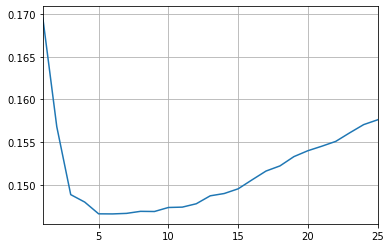

In [50]:
x = rmse_knn['n']
y = rmse_knn['rmse']

plt.plot(x, y)
plt.xlim(1, 25) 
plt.grid()
plt.show()

In [51]:
from sklearn.neighbors import KNeighborsRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model2 = KNeighborsRegressor(n_neighbors = 11)
model2.fit(x,y)

y_hat = model2.predict(x)

from sklearn.metrics import mean_squared_error
model2_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(train_rmse)

model2_cv_rmse = cross_validation(df1,KNeighborsRegressor(n_neighbors = 11))

In [52]:
from sklearn.tree import DecisionTreeRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

mse2 = []

for i in range(1,20,1):
    reg = DecisionTreeRegressor(max_depth=i).fit(x,y)
    y_hat = reg.predict(x)
    mse2.append(cross_validation(df1,DecisionTreeRegressor(max_depth=i)))

In [53]:
rmse_tree = pd.DataFrame(zip(np.linspace(1,len(mse2),len(mse2)), mse2), columns = ['n','rmse'])
rmse_tree.loc[rmse_tree['rmse'] == rmse_tree['rmse'].min()]
#rmse_tree['rmse'].min()
#rmse_tree
#max_depth = 6 produced the smallest mse

,n,rmse
7,8.0,0.192819


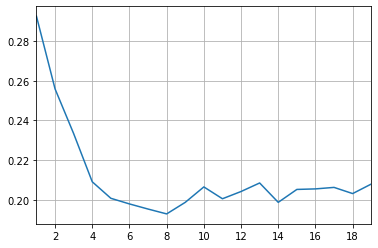

In [54]:
x = rmse_tree['n']
y = rmse_tree['rmse']

plt.plot(x, y)
plt.xlim(1, 19)  
plt.grid()
plt.show()

In [55]:
from sklearn.tree import DecisionTreeRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model3 = DecisionTreeRegressor(max_depth=6)
model3.fit(x,y)

y_hat = model3.predict(x)

from sklearn.metrics import mean_squared_error
model3_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(train_rmse)

model3_cv_rmse = cross_validation(df1,DecisionTreeRegressor(max_depth=6))

<BarContainer object of 9 artists>

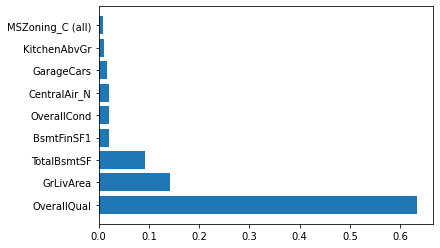

In [56]:
df_feature = pd.DataFrame(zip(x.columns, model3.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])

In [57]:
# random forest
from sklearn.ensemble import RandomForestRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model4 = RandomForestRegressor()
model4.fit(x,y)

y_hat = model4.predict(x)

from sklearn.metrics import mean_squared_error
model4_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(train_rmse)

model4_cv_rmse = cross_validation(df1,RandomForestRegressor())

<BarContainer object of 9 artists>

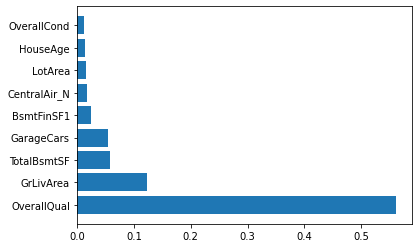

In [58]:
df_feature = pd.DataFrame(zip(x.columns, model4.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])

In [59]:
# bagging
from sklearn.ensemble import BaggingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model5 = BaggingRegressor()
model5.fit(x,y)

y_hat = model5.predict(x)

from sklearn.metrics import mean_squared_error
model5_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(train_rmse)

model5_cv_rmse = cross_validation(df1,BaggingRegressor())

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

cols = ['i', 'j', 'rmse']
lst = []

#mse3 = pd.DataFrame(columns = ['i', 'j', 'mse'])

for i in range(3,7,1):
    for j in range(3,7,1):
        gbr_params = {'n_estimators': 1000,
          'max_depth': i,
          'min_samples_split': j,
          'learning_rate': 0.01,
          'loss': 'ls'}
        
        reg = GradientBoostingRegressor(**gbr_params).fit(x,y)
        y_hat = reg.predict(x)
        
        from sklearn.metrics import mean_squared_error
        #mse = mean_squared_error(y, y_hat, squared=False)
        mse = cross_validation(df1, GradientBoostingRegressor(**gbr_params))
        lst.append([i,j,mse])
        mse3  = pd.DataFrame(lst, columns = cols)
        
#mse3

In [61]:
mse3.loc[mse3['rmse'] == mse3['rmse'].min()]

,i,j,rmse
7,4,6,0.124324


In [62]:
mse3

,i,j,rmse
0,3,3,0.126555
1,3,4,0.126507
2,3,5,0.126753
3,3,6,0.126142
4,4,3,0.124508
5,4,4,0.124599
6,4,5,0.124882
7,4,6,0.124324
8,5,3,0.126090
9,5,4,0.126601


In [63]:
# boosting
from sklearn.ensemble import GradientBoostingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 6,
          'learning_rate': 0.01,
          'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
model6 = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
model6.fit(x, y)

y_hat = model6.predict(x)

from sklearn.metrics import mean_squared_error
model6_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(train_rmse)

model6_cv_rmse = cross_validation(df1,GradientBoostingRegressor(**gbr_params))

<BarContainer object of 9 artists>

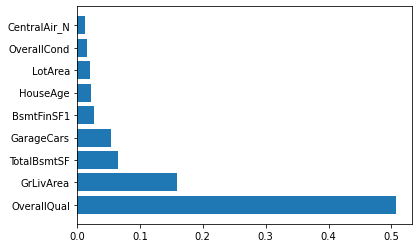

In [64]:
df_feature = pd.DataFrame(zip(x.columns, model6.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])

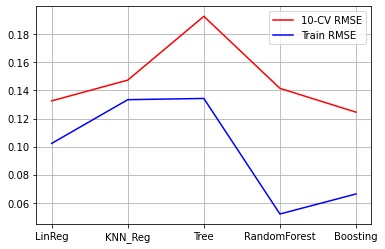

In [68]:
x = ['LinReg', 'KNN_Reg', 'Tree', 'RandomForest', 'Boosting']
y1 = [model_train_rmse, model2_train_rmse, model3_train_rmse, model4_train_rmse, model6_train_rmse]
y2 = [model_cv_rmse, model2_cv_rmse, model3_cv_rmse, model4_cv_rmse, model6_cv_rmse]

plt.plot(x, y2, label = "10-CV RMSE", c='r')
plt.plot(x, y1, label = "Train RMSE", c='b')
plt.legend()
plt.grid()
plt.show()

In [69]:
y1

[0.102289441660338,
 0.13343957738067785,
 0.13431419863052627,
 0.05201845975777225,
 0.06629748928379645]

In [70]:
y2

[0.1325898278008975,
 0.14736780779336406,
 0.1927963857522983,
 0.14150529959490377,
 0.12453399026316808]